# Project 1 Neuronal networks

## 1.- MNIST and FMINST datasets

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [ ]:
!pip install wandb
import wandb # Weight & Biases library to monitor training and compare models
wandb.login() # API key: 569de9861dbe18fe8888f13ca66e39d2b12934ff

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

To obtain the MNIST dataset:

In [ ]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_MNIST = torch.utils.data.DataLoader(trainsetMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_MNIST = torch.utils.data.DataLoader(testsetMNIST, batch_size=64, shuffle=True)

To obtain the FMINST dataset:

In [ ]:

# Download and load the training data
trainsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_FMNIST = torch.utils.data.DataLoader(trainsetFMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_FMNIST = torch.utils.data.DataLoader(testsetFMNIST, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(train_MNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


In [ ]:
dataiter = iter(train_FMNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


We can see that our images are of size 28 x 28 = 784, so the input layer is of size 784. It is important to see that the range of the values are -1,1 so for the output layer we will use the tanh.

We also need to split the training data into training and validation sets.

In [ ]:
import copy


valid_MNIST = copy.deepcopy(train_MNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_MNIST.dataset.data = train_MNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_MNIST.dataset.data = valid_MNIST.dataset.data[45000:,:,:]


In [ ]:
import copy

valid_FMNIST = copy.deepcopy(train_FMNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_FMNIST.dataset.data = train_FMNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_FMNIST.dataset.data = valid_FMNIST.dataset.data[45000:,:,:]

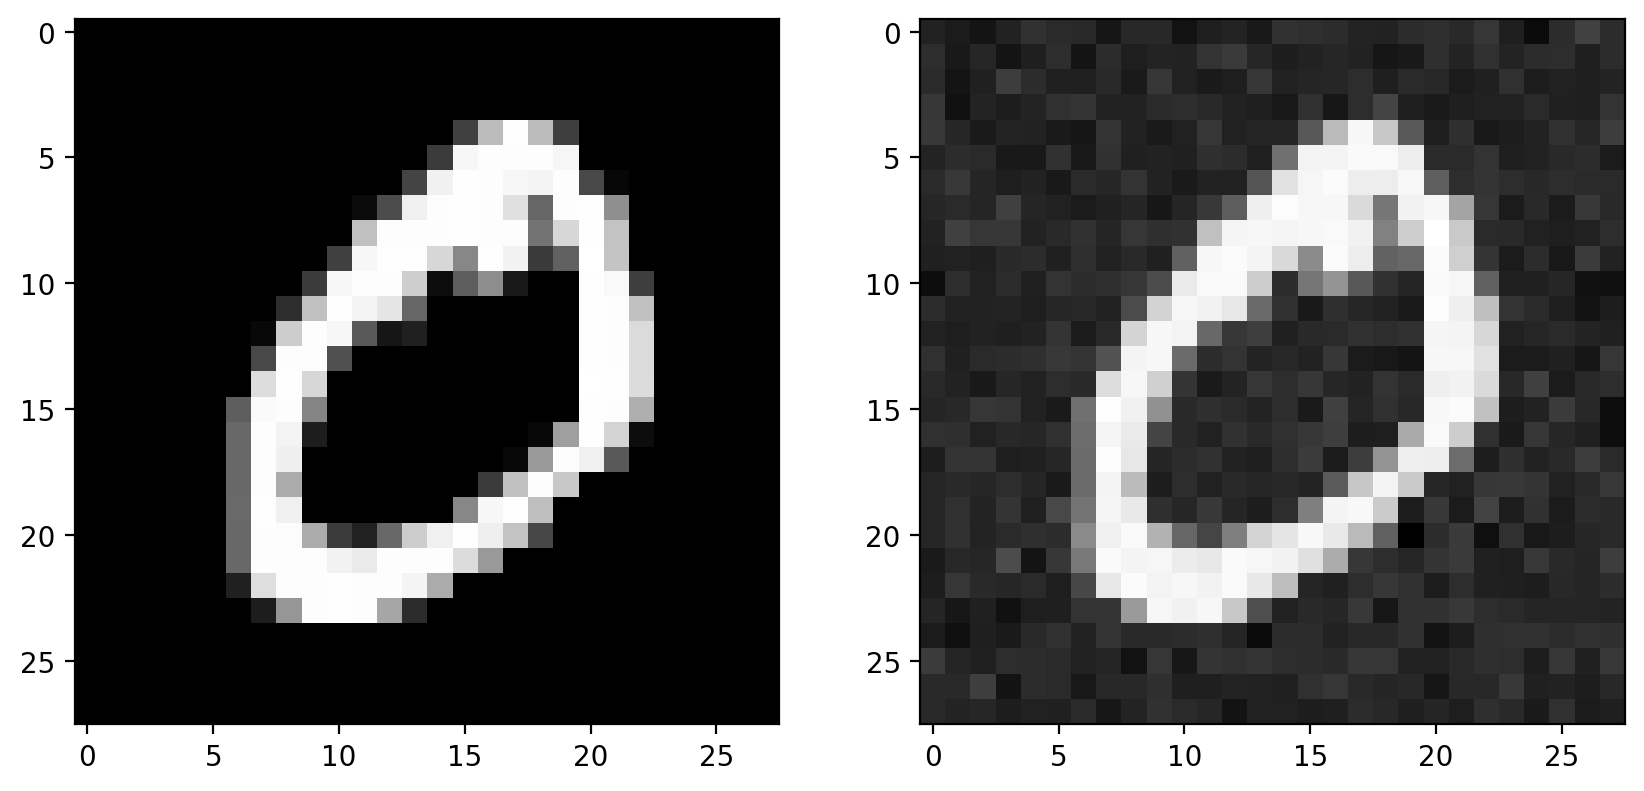

In [ ]:
def add_noise(img, variance):
    noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=img.shape)
    noisy_img = img + noise
    return noisy_img


img = train_MNIST.dataset.data[1,:,:]
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(add_noise(img,100).numpy().reshape([28,28]), cmap='Greys_r')



Select Data Set To Be Trained:

In [ ]:
INDEX = 0 # INDEX = 0 for MNIST and 1 for FMNIST!

train_set = [train_MNIST, train_FMNIST]
valid_set = [valid_MNIST, valid_FMNIST]

## 3 layers at both encoder/decoder:


In [ ]:

class autoencoder3(nn.Module):
    def __init__(self, projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001


        if INDEX == 0:  # MNIST
            self.name_train = f"3_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img_noised = add_noise(img,4)
                img = img.reshape(-1, self.input_image_size)
                img_noised = img_noised.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img_noised.float())

                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    img_noised = add_noise(images,4)
                    img_noised = img_noised.reshape(-1, self.input_image_size)
                    images = images.reshape(-1, self.input_image_size)
                    encod,reconstruct = self.forward(img_noised.float())

                    loss_valid = self.criterion(reconstruct,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

Definition of parameters of the model and Peak signal-to-noise ratio (PSNR)

Training the model

In [ ]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
epochs = 30
models_autoencoder3 = []
for run in range(len(projected_dimensions)):
    model = autoencoder3(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX],valid_set[INDEX])
    models_autoencoder3.append(model)

Loss train,█▂▁
Loss valid,█▃▁
projected dimension,▁▁▁
Loss train,0.1525
Loss valid,0.14927
projected dimension,15


Epoch:  1 Loss train:  0.19829971523193474 , Loss valid:  0.15963333718320158
Epoch:  2 Loss train:  0.14906021014956589 , Loss valid:  0.14448831056026704
Epoch:  3 Loss train:  0.13886073360812257 , Loss valid:  0.1360246424028214
Epoch:  4 Loss train:  0.1333114145725796 , Loss valid:  0.1327905753825573
Epoch:  5 Loss train:  0.12965562198819083 , Loss valid:  0.1295517786703211
Epoch:  6 Loss train:  0.12721187144052237 , Loss valid:  0.12701536664303312
Epoch:  7 Loss train:  0.1254952151264826 , Loss valid:  0.12742734557770669
Epoch:  8 Loss train:  0.12409791280515492 , Loss valid:  0.12445256307404091
Epoch:  9 Loss train:  0.1229489652799781 , Loss valid:  0.1231211875347381
Epoch:  10 Loss train:  0.12208090214566751 , Loss valid:  0.12340830377441772
Epoch:  11 Loss train:  0.12117214238440449 , Loss valid:  0.1226332128364989
Epoch:  12 Loss train:  0.1205405541272326 , Loss valid:  0.1218632530658803
Epoch:  13 Loss train:  0.11967393251093612 , Loss valid:  0.1213540263

KeyboardInterrupt: 

Visualization of reconstructed images

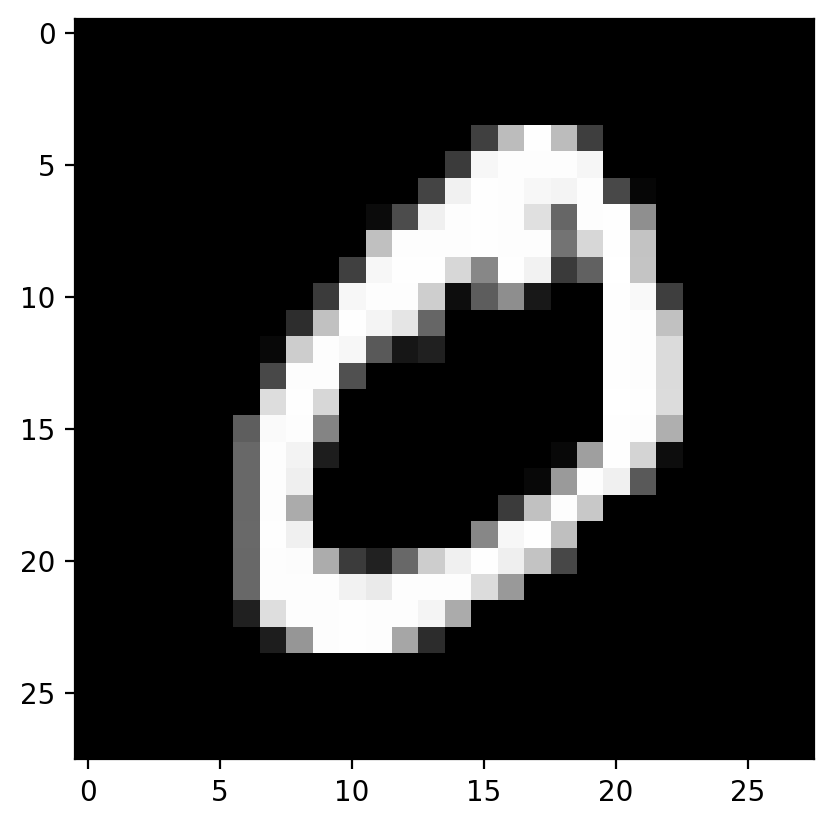

In [ ]:
img = train_set[INDEX].dataset.data[1,:,:]
noised_img = add_noise(img, 100)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

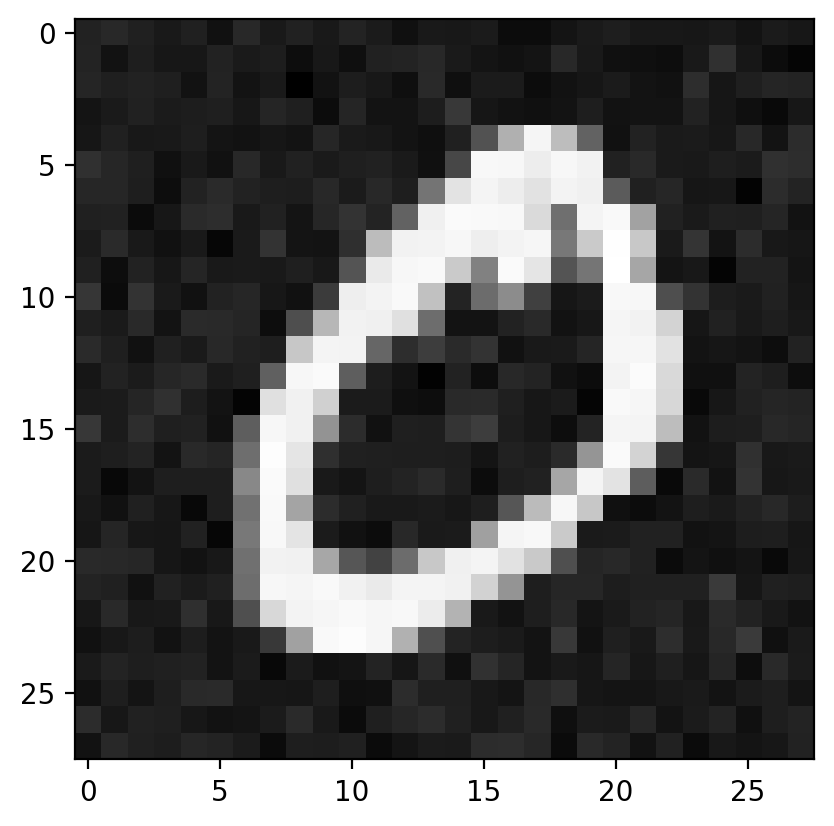

In [ ]:
plt.imshow(noised_img.numpy().reshape([28,28]), cmap='Greys_r')

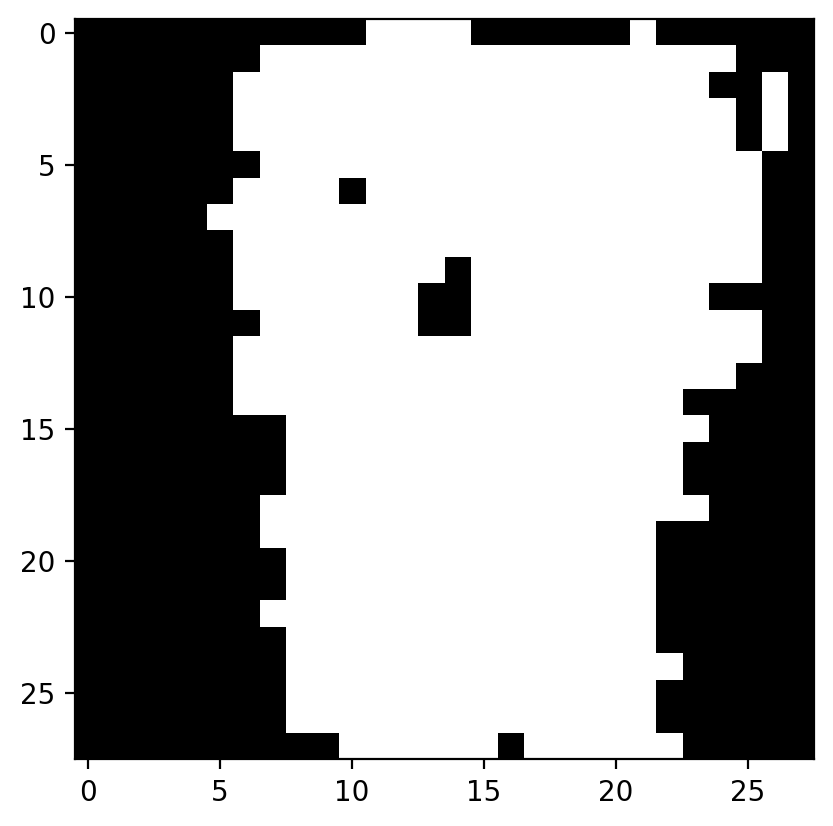

In [ ]:
noised_img = noised_img.reshape(-1, 784)
reconstructed = models_autoencoder3[-1].forward(noised_img.float())
plt.imshow(reconstructed.detach().numpy().reshape([28,28]))

# 5 layers at both encoder/decoder:

In [ ]:
class autoencoder5(nn.Module):
    def __init__(self,projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001

        if INDEX == 0:  # MNIST
            self.name_train = f"5_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")


        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension),
            nn.ReLU()
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )

        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()


        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = self.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

In [ ]:
projected_dimensions = [15, 30, 50, 100]
epochs = 30
models_autoencoder5 = []
for run in range(len(projected_dimensions)):
    model = autoencoder5(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_MNIST,valid_MNIST)
    models_autoencoder5.append(model)

Epoch:  1 Loss train:  0.20077844192697245 , Loss valid:  0.1356616902858653
Epoch:  2 Loss train:  0.1157607698220421 , Loss valid:  0.1080688124641459
Epoch:  3 Loss train:  0.09600080065005882 , Loss valid:  0.09233898647288058
Epoch:  4 Loss train:  0.08391867596021091 , Loss valid:  0.08282232848887748
Epoch:  5 Loss train:  0.07606320489536632 , Loss valid:  0.07562803278895135
Epoch:  6 Loss train:  0.07089229322842915 , Loss valid:  0.07257152074512015
Epoch:  7 Loss train:  0.06700879758202725 , Loss valid:  0.06939082621259893
Epoch:  8 Loss train:  0.06354055282215333 , Loss valid:  0.06636984101001253
Epoch:  9 Loss train:  0.06118786719691178 , Loss valid:  0.06494162865775696
Epoch:  10 Loss train:  0.05900059616066177 , Loss valid:  0.06250537735350589
Epoch:  11 Loss train:  0.057015409529082135 , Loss valid:  0.061052669600603425
Epoch:  12 Loss train:  0.05568939947459677 , Loss valid:  0.0606036828236377
Epoch:  13 Loss train:  0.0543986147491854 , Loss valid:  0.059

Loss train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04056
Loss valid,0.04801
projected dimension,15


Epoch:  1 Loss train:  0.19922852268527177 , Loss valid:  0.13369552705516208
Epoch:  2 Loss train:  0.12055318511556834 , Loss valid:  0.11718746357141657
Epoch:  3 Loss train:  0.10608258336486126 , Loss valid:  0.10046215634396735
Epoch:  4 Loss train:  0.09368769745130769 , Loss valid:  0.09404523046092784
Epoch:  5 Loss train:  0.08608981446278366 , Loss valid:  0.08715246072474947
Epoch:  6 Loss train:  0.08090042814993384 , Loss valid:  0.08268086456872047
Epoch:  7 Loss train:  0.07597024341389029 , Loss valid:  0.07805770337581634
Epoch:  8 Loss train:  0.07159080520399254 , Loss valid:  0.07399376505549918
Epoch:  9 Loss train:  0.06714461791456085 , Loss valid:  0.07006471077812479
Epoch:  10 Loss train:  0.06345001743069258 , Loss valid:  0.06616939602697149
Epoch:  11 Loss train:  0.060877952269617126 , Loss valid:  0.06278120577335358
Epoch:  12 Loss train:  0.05824704375118017 , Loss valid:  0.06264892489986217
Epoch:  13 Loss train:  0.05651078119461255 , Loss valid:  0

Loss train,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04016
Loss valid,0.0481
projected dimension,30


Epoch:  1 Loss train:  0.19839657706589522 , Loss valid:  0.14230850874743564
Epoch:  2 Loss train:  0.11739652228160677 , Loss valid:  0.10555442197525755
Epoch:  3 Loss train:  0.09688997444358062 , Loss valid:  0.09422711783901173
Epoch:  4 Loss train:  0.08791299931577999 , Loss valid:  0.0875931127908382
Epoch:  5 Loss train:  0.0825973098822446 , Loss valid:  0.08333970793384186
Epoch:  6 Loss train:  0.07873110357798975 , Loss valid:  0.08025642119823619
Epoch:  7 Loss train:  0.07448138066948476 , Loss valid:  0.07709320650455799
Epoch:  8 Loss train:  0.07066606568299573 , Loss valid:  0.07298197506907138
Epoch:  9 Loss train:  0.06770726017632776 , Loss valid:  0.07227062221537245
Epoch:  10 Loss train:  0.0656058314806697 , Loss valid:  0.071539533978447
Epoch:  11 Loss train:  0.06342142094349996 , Loss valid:  0.06850719347279123
Epoch:  12 Loss train:  0.061679556135045874 , Loss valid:  0.06564865787612631
Epoch:  13 Loss train:  0.060005911631213334 , Loss valid:  0.064

Loss train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04226
Loss valid,0.04954
projected dimension,50


Epoch:  1 Loss train:  0.19779753862795504 , Loss valid:  0.13620411839256896
Epoch:  2 Loss train:  0.11310057162137871 , Loss valid:  0.10450149371902993
Epoch:  3 Loss train:  0.09490237774496729 , Loss valid:  0.09156296246863425
Epoch:  4 Loss train:  0.08635214165869085 , Loss valid:  0.08632210692826738
Epoch:  5 Loss train:  0.08191924073352394 , Loss valid:  0.0822024996927444
Epoch:  6 Loss train:  0.07818649153606119 , Loss valid:  0.0813122403748492
Epoch:  7 Loss train:  0.07611859231044284 , Loss valid:  0.07836050096344441
Epoch:  8 Loss train:  0.07372488873608579 , Loss valid:  0.07678172710411092
Epoch:  9 Loss train:  0.07119166299658404 , Loss valid:  0.07356274898381944
Epoch:  10 Loss train:  0.06807761462087827 , Loss valid:  0.07052806734721712
Epoch:  11 Loss train:  0.06443495191210373 , Loss valid:  0.06741605884534248
Epoch:  12 Loss train:  0.0615486670920456 , Loss valid:  0.0676705056841069
Epoch:  13 Loss train:  0.05943756963824853 , Loss valid:  0.0625

Loss train,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04142
Loss valid,0.04831
projected dimension,100


# Save the models

In [ ]:
if INDEX == 0:  # MNIST
  for i in range(len(models_autoencoder3)):
    torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_MNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_MNIST_{projected_dimensions[i]}.pth')
elif INDEX == 1:  # FMNIST
  for i in range(len(models_autoencoder3)):
    torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_FMNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_FMNIST_{projected_dimensions[i]}.pth')

else:
        raise ValueError("While saving the models, INDEX should be either 0 or 1.")

Load the models

In [ ]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
models_autoencoder3 = []
models_autoencoder5 = []

if INDEX == 0:  # MNIST
  dataset0 = "MNIST"
else:
  dataset0 = "FMNIST"

for i in range(4):
    state_dict = torch.load(f'model_autoencoder3_{dataset0}_{projected_dimensions[i]}.pth')
    model_3 = autoencoder3(projected_dimensions[i])
    model_3.load_state_dict(state_dict)
    models_autoencoder3.append(model_3)

    state_dict = torch.load(f'model_autoencoder5_{dataset0}_{projected_dimensions[i]}.pth')
    model_5 = autoencoder5(projected_dimensions[i])
    model_5.load_state_dict(state_dict)
    models_autoencoder5.append(model_5)

Evaluation of the performance of the models without regularization

In [ ]:
def evaluate_model(models, train, valid, test):
    for n_layers in range(len(models)):
        for i, model in enumerate(models[n_layers]):
            n_lay = 3 if n_layers == 0 else 5
            print(f"Autoenc{n_lay}, train-{projected_dimensions[i]}. Projections:", model.eval_performance(train))
            print(f"Autoenc{n_lay}, val-{projected_dimensions[i]}. Projections:", model.eval_performance(valid))
            print(f"Autoenc{n_lay}, test-{projected_dimensions[i]}. Projections:", model.eval_performance(test), "\n")

In [ ]:
models = [models_autoencoder3, models_autoencoder5]
evaluate_model(models, train_MNIST, valid_MNIST, test_MNIST)

After analysing the losses of the train and validation sets we can see that we can apply early stopping in 15 epochs because the validation loss is getting small slowly after that point.

## Training the models with early stopping, dropout and Lasso regularization

In [ ]:

class autoencoder3_regularized(nn.Module):
    def __init__(self, projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.lambd = 1e-5

        if INDEX == 0:  # MNIST
            self.name_train = f"3_layer_train_dropout_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_test_dropout_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_train_dropout_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_test_dropout_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img)
                l1_reg = torch.abs(enco).sum()
                loss_train = self.criterion(reconstructed, img) + self.lambd*l1_reg

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    enco,out = self.forward(images)
                    l1_reg = torch.abs(enco).sum()
                    loss_valid = self.criterion(out,images) + self.lambd*l1_reg

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance


In [ ]:
projected_dimensions = [15, 30, 50, 100]
epochs = 15
models_autoencoder3_regularized = []
for run in range(len(projected_dimensions)):
    model = autoencoder3_regularized(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX],valid_set[INDEX])
    models_autoencoder3_regularized.append(model)

Epoch:  1 Loss train:  0.22782868925820698 , Loss valid:  0.15837436128169932
Epoch:  2 Loss train:  0.15201256942765956 , Loss valid:  0.125970503339108
Epoch:  3 Loss train:  0.13685291483786635 , Loss valid:  0.11563253916324454
Epoch:  4 Loss train:  0.1303542666666379 , Loss valid:  0.11153586706582536
Epoch:  5 Loss train:  0.12659378260882062 , Loss valid:  0.1071957529542294
Epoch:  6 Loss train:  0.12384715944062918 , Loss valid:  0.10340829203103451
Epoch:  7 Loss train:  0.12150243038988927 , Loss valid:  0.10232620867008858
Epoch:  8 Loss train:  0.11975220236292278 , Loss valid:  0.09861256251943873
Epoch:  9 Loss train:  0.11797261773608625 , Loss valid:  0.09740339165672343
Epoch:  10 Loss train:  0.11682387021243233 , Loss valid:  0.09592733341962734
Epoch:  11 Loss train:  0.11550909002438527 , Loss valid:  0.09749492923630045
Epoch:  12 Loss train:  0.11470087728759443 , Loss valid:  0.09427071644904765
Epoch:  13 Loss train:  0.11394568003544753 , Loss valid:  0.0925

Loss train,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Loss valid,█▅▃▃▃▂▂▂▂▁▂▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.11247
Loss valid,0.09228
projected dimension,15


Epoch:  1 Loss train:  0.2045550347644497 , Loss valid:  0.13762912461732296
Epoch:  2 Loss train:  0.14252104188992895 , Loss valid:  0.1203300175514627
Epoch:  3 Loss train:  0.13230725664603102 , Loss valid:  0.11244389208707403
Epoch:  4 Loss train:  0.12667689367663115 , Loss valid:  0.10643104593804542
Epoch:  5 Loss train:  0.12306483285713264 , Loss valid:  0.10265027141951501
Epoch:  6 Loss train:  0.12012193486390804 , Loss valid:  0.10063265324273007
Epoch:  7 Loss train:  0.11832008203914897 , Loss valid:  0.09838333567406268
Epoch:  8 Loss train:  0.1167009014276449 , Loss valid:  0.09603991562381704
Epoch:  9 Loss train:  0.11582288476215168 , Loss valid:  0.09629885643086535
Epoch:  10 Loss train:  0.11438742510720411 , Loss valid:  0.09386948943138122
Epoch:  11 Loss train:  0.11344247261612592 , Loss valid:  0.09245604416157337
Epoch:  12 Loss train:  0.11268736535302279 , Loss valid:  0.09213812367079106
Epoch:  13 Loss train:  0.1120130894493989 , Loss valid:  0.0909

Loss train,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
Loss valid,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.11074
Loss valid,0.08954
projected dimension,30


Epoch:  1 Loss train:  0.21269710110077125 , Loss valid:  0.1445105050472503
Epoch:  2 Loss train:  0.14445962407626212 , Loss valid:  0.11977625650928375
Epoch:  3 Loss train:  0.13175157526380976 , Loss valid:  0.11205998741565866
Epoch:  4 Loss train:  0.1260522570122372 , Loss valid:  0.10567382155580723
Epoch:  5 Loss train:  0.12201848131900822 , Loss valid:  0.10258489729876213
Epoch:  6 Loss train:  0.11886995402164757 , Loss valid:  0.09749285515318526
Epoch:  7 Loss train:  0.11616308393422514 , Loss valid:  0.09488396508262513
Epoch:  8 Loss train:  0.1137643140656027 , Loss valid:  0.09261166538963926
Epoch:  9 Loss train:  0.11212442623747682 , Loss valid:  0.09156868479987408
Epoch:  10 Loss train:  0.11078596217769453 , Loss valid:  0.08964921020446939
Epoch:  11 Loss train:  0.10947506326589394 , Loss valid:  0.08791859879138622
Epoch:  12 Loss train:  0.10860589303245599 , Loss valid:  0.08783839237182699
Epoch:  13 Loss train:  0.10792757104023952 , Loss valid:  0.086

Loss train,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
Loss valid,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.10663
Loss valid,0.08427
projected dimension,50


Epoch:  1 Loss train:  0.21593732357194478 , Loss valid:  0.14748767424137035
Epoch:  2 Loss train:  0.1473130741770464 , Loss valid:  0.12315397611323824
Epoch:  3 Loss train:  0.13494708470534533 , Loss valid:  0.11418680954486765
Epoch:  4 Loss train:  0.12877259157936682 , Loss valid:  0.10832215221004284
Epoch:  5 Loss train:  0.12371902685316111 , Loss valid:  0.10198395363193877
Epoch:  6 Loss train:  0.11982256143396212 , Loss valid:  0.09789036499693039
Epoch:  7 Loss train:  0.11688328593630683 , Loss valid:  0.09501549839339357
Epoch:  8 Loss train:  0.11472883971873671 , Loss valid:  0.09311594585789011
Epoch:  9 Loss train:  0.11296087135137482 , Loss valid:  0.08981770159716301
Epoch:  10 Loss train:  0.11126374481880869 , Loss valid:  0.08945085476053521
Epoch:  11 Loss train:  0.11025044801433316 , Loss valid:  0.08720949802626955
Epoch:  12 Loss train:  0.10925794611896643 , Loss valid:  0.08682766011420717
Epoch:  13 Loss train:  0.10809589937244626 , Loss valid:  0.0

Loss train,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
Loss valid,█▅▄▄▃▃▂▂▂▂▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.10687
Loss valid,0.08418
projected dimension,100


In [ ]:
class autoencoder5_regularized(nn.Module):
    def __init__(self, projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.lambd = 1e-5

        if INDEX == 0:  # MNIST
            self.name_train = f"5_layer_train_dropout_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_test_dropout_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_train_dropout_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_test_dropout_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img)
                l1_reg = torch.abs(enco).sum()
                loss_train = self.criterion(reconstructed, img) + self.lambd*l1_reg

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    enco,out = self.forward(images)
                    l1_reg = torch.abs(enco).sum()
                    loss_valid = self.criterion(out,images) + self.lambd*l1_reg

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance


In [ ]:
projected_dimensions = [15, 30, 50, 100]
epochs = 15
models_autoencoder5_regularized = []
for run in range(len(projected_dimensions)):
    model = autoencoder5_regularized(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX],valid_set[INDEX])
    models_autoencoder5_regularized.append(model)

Loss train,█▁
Loss valid,█▁
projected dimension,▁▁
Loss train,0.27002
Loss valid,0.26809
projected dimension,15


Epoch:  1 Loss train:  0.23074341904033313 , Loss valid:  0.19307326845666195
Epoch:  2 Loss train:  0.18792261651039802 , Loss valid:  0.16815112417048597
Epoch:  3 Loss train:  0.16985737619159574 , Loss valid:  0.15195518376979422
Epoch:  4 Loss train:  0.1596825847148218 , Loss valid:  0.14436875026910864
Epoch:  5 Loss train:  0.15354948164895177 , Loss valid:  0.13786643908378926
Epoch:  6 Loss train:  0.14888849026862194 , Loss valid:  0.13342522014962865
Epoch:  7 Loss train:  0.14587806613946502 , Loss valid:  0.1298463669229061
Epoch:  8 Loss train:  0.14378158768257973 , Loss valid:  0.12733435703718915
Epoch:  9 Loss train:  0.14166128642814743 , Loss valid:  0.12555837272963624
Epoch:  10 Loss train:  0.14004102790601214 , Loss valid:  0.12504304355763374
Epoch:  11 Loss train:  0.13904528491283683 , Loss valid:  0.12186426181108394
Epoch:  12 Loss train:  0.13754670643670994 , Loss valid:  0.12047508133852736
Epoch:  13 Loss train:  0.13670937688386237 , Loss valid:  0.11

Loss train,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
Loss valid,█▆▄▄▃▂▂▂▂▂▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.13515
Loss valid,0.11726
projected dimension,15


Epoch:  1 Loss train:  0.23252248459241606 , Loss valid:  0.19315626431018748
Epoch:  2 Loss train:  0.1897460100325671 , Loss valid:  0.16893673234797538
Epoch:  3 Loss train:  0.17275827860629017 , Loss valid:  0.1570549061323734
Epoch:  4 Loss train:  0.16423684333197094 , Loss valid:  0.1489054263272184
Epoch:  5 Loss train:  0.1593531822277741 , Loss valid:  0.14539971164566406
Epoch:  6 Loss train:  0.15620334207249637 , Loss valid:  0.14063529365874353
Epoch:  7 Loss train:  0.15330921712500806 , Loss valid:  0.1404084362565203
Epoch:  8 Loss train:  0.15145223390903662 , Loss valid:  0.1375239687714171
Epoch:  9 Loss train:  0.14935290428217163 , Loss valid:  0.1367424579059824
Epoch:  10 Loss train:  0.14765998043797232 , Loss valid:  0.13373064883845917
Epoch:  11 Loss train:  0.1458543959200721 , Loss valid:  0.13395235066084152
Epoch:  12 Loss train:  0.14512481286444448 , Loss valid:  0.13114710836968524
Epoch:  13 Loss train:  0.14361575553828682 , Loss valid:  0.12891048

Loss train,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁
Loss valid,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.14176
Loss valid,0.1276
projected dimension,30


Epoch:  1 Loss train:  0.230389319550754 , Loss valid:  0.18839815816980726
Epoch:  2 Loss train:  0.18992079819806598 , Loss valid:  0.1734864519631609
Epoch:  3 Loss train:  0.17140006549148398 , Loss valid:  0.15132505881025435
Epoch:  4 Loss train:  0.157927543327043 , Loss valid:  0.13974974475642468
Epoch:  5 Loss train:  0.15043749660253525 , Loss valid:  0.13389171485571152
Epoch:  6 Loss train:  0.14575848477596248 , Loss valid:  0.12858670569480735
Epoch:  7 Loss train:  0.14232890812722457 , Loss valid:  0.12507025425104384
Epoch:  8 Loss train:  0.1399782185167582 , Loss valid:  0.12230890009631502
Epoch:  9 Loss train:  0.13810955665328287 , Loss valid:  0.12070750923866921
Epoch:  10 Loss train:  0.13666178056419911 , Loss valid:  0.11960124176867465
Epoch:  11 Loss train:  0.135636252139441 , Loss valid:  0.11750909587804308
Epoch:  12 Loss train:  0.13439959125720302 , Loss valid:  0.11632999035906284
Epoch:  13 Loss train:  0.13313251623714512 , Loss valid:  0.11471648

Loss train,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
Loss valid,█▇▅▃▃▂▂▂▂▂▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.13193
Loss valid,0.11345
projected dimension,50


Epoch:  1 Loss train:  0.2316049205520275 , Loss valid:  0.19010703614417543
Epoch:  2 Loss train:  0.188900798516856 , Loss valid:  0.16676025473056955
Epoch:  3 Loss train:  0.16755984969098459 , Loss valid:  0.146912075769394
Epoch:  4 Loss train:  0.15416566579898988 , Loss valid:  0.13590319752693175
Epoch:  5 Loss train:  0.14728181195360693 , Loss valid:  0.12981798490311236
Epoch:  6 Loss train:  0.14306302855468608 , Loss valid:  0.1260206366790102
Epoch:  7 Loss train:  0.14029198373794893 , Loss valid:  0.12265504221332835
Epoch:  8 Loss train:  0.1380722453203899 , Loss valid:  0.12019189123777634
Epoch:  9 Loss train:  0.13647876439658416 , Loss valid:  0.11846645151046996
Epoch:  10 Loss train:  0.13512931908057493 , Loss valid:  0.11705676510613015
Epoch:  11 Loss train:  0.13405104325449263 , Loss valid:  0.11513249718762458
Epoch:  12 Loss train:  0.1329118887661025 , Loss valid:  0.11493890621560685
Epoch:  13 Loss train:  0.13181332156951117 , Loss valid:  0.11531712

Loss train,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
Loss valid,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.12999
Loss valid,0.1109
projected dimension,100


Save the models

In [ ]:
if INDEX == 0:  # MNIST
  for i in range(len(models_autoencoder3_regularized)):
    torch.save(models_autoencoder3_regularized[i].state_dict(), f'model_autoencoder3_regularized_MNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5_regularized[i].state_dict(), f'model_autoencoder5_regularized_MNIST_{projected_dimensions[i]}.pth')
elif INDEX == 1:  # FMNIST
  for i in range(len(models_autoencoder3_regularized)):
    torch.save(models_autoencoder3_regularized[i].state_dict(), f'model_autoencoder3_regularized_FMNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5_regularized[i].state_dict(), f'model_autoencoder5_regularized_FMNIST_{projected_dimensions[i]}.pth')

else:
        raise ValueError("While saving the models, INDEX should be either 0 or 1.")

Load the models

In [ ]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
models_autoencoder3 = []
models_autoencoder5 = []

if INDEX == 0:  # MNIST
  dataset0 = "MNIST"
else:
  dataset0 = "FMNIST"

for i in range(4):
    state_dict = torch.load(f'model_autoencoder3_regularized_{dataset0}_{projected_dimensions[i]}.pth')
    model_3 = autoencoder3_regularized(projected_dimensions[i])
    model_3.load_state_dict(state_dict)
    models_autoencoder3.append(model_3)

    state_dict = torch.load(f'model_autoencoder5_regularized_{dataset0}_{projected_dimensions[i]}.pth')
    model_5 = autoencoder5_regularized(projected_dimensions[i])
    model_5.load_state_dict(state_dict)
    models_autoencoder5.append(model_5)

RuntimeError: Error(s) in loading state_dict for autoencoder5:
	Missing key(s) in state_dict: "encoder.2.weight", "encoder.2.bias", "encoder.4.weight", "encoder.4.bias", "encoder.8.weight", "encoder.8.bias", "decoder.2.weight", "decoder.2.bias", "decoder.4.weight", "decoder.4.bias", "decoder.8.weight", "decoder.8.bias". 
	Unexpected key(s) in state_dict: "encoder.9.weight", "encoder.9.bias", "encoder.12.weight", "encoder.12.bias", "encoder.3.weight", "encoder.3.bias", "decoder.12.weight", "decoder.12.bias", "decoder.3.weight", "decoder.3.bias", "decoder.9.weight", "decoder.9.bias". 
	size mismatch for encoder.6.weight: copying a param with shape torch.Size([300, 400]) from checkpoint, the shape in current model is torch.Size([200, 300]).
	size mismatch for encoder.6.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([400, 300]) from checkpoint, the shape in current model is torch.Size([550, 400]).
	size mismatch for decoder.6.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([550]).

Evaluation of performance after regularization

In [ ]:
models = [models_autoencoder3_regularized, models_autoencoder5_regularized]
evaluate_model(models, train_MNIST, valid_MNIST, test_MNIST)

AttributeError: 'tuple' object has no attribute 'size'

After looking at the performance we have chosen the model with

# Denoising autoencoder

Now for the best model we have found we will train a new one with noisy images and compare the output with the original ones. We will tune the variance of the noise we are introducing

Visualization of the denoising autoencoder